In [240]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import sklearn
import sklearn.neural_network
import sknn
from sknn import mlp
from sklearn import datasets
import requests
import json

from mpl_toolkits.basemap import Basemap

In [2]:
# feature scaling for large variables
def normalize_data(df, var):
    mu = np.mean(df[var])
    sig = np.std(df[var])
    df[var] = (df[var] - mu) / sig
    return df

In [3]:
# import datasets

# we use names as keys for idnetifying unique properties. these are cleaned up property names
propertynames = pd.read_csv('/Users/kyu/Downloads/cleanName2.csv', header=None)

# solar installation data for boston
solar = pd.read_csv('./boston_data.csv')

# property assessment data for boston
propertyAssessment = pd.read_csv('/Users/kyu/Downloads/Property_Assessment_2014.csv')

//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (6,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
# reset values for owner field with the cleaned up names
propertyAssessment['OWNER'] = propertynames

In [6]:
# sizes of arrays
n_houses = solar.shape[0]
n_predictors = propertyAssessment.shape[1]

In [8]:
# remove industrial and commercial land use
ind = (propertyAssessment['LU'].values != 'CD') & (propertyAssessment['LU'].values != 'CM') & \
(propertyAssessment['LU'].values != 'C') & \
(propertyAssessment['LU'].values != 'RC') & (propertyAssessment['LU'].values != 'CL') & \
(propertyAssessment['LU'].values != 'CP') & \
(propertyAssessment['LU'].values != 'I') & (propertyAssessment['LU'].values != 'CD') & \
(propertyAssessment['LU'].values != 'E') & \
(propertyAssessment['LU'].values != 'EA')

propertyData = propertyAssessment[ind]

# convert to numeric codes
propertyData = propertyData[['OWNER', 'LU', 'NUM_FLOORS', 'AV_BLDG', 'YR_BUILT', 'R_AC', 'OWN_OCC', \
                             'R_TOTAL_RMS', 'GROSS_TAX', 'R_ROOF_TYP']]
LU = ['R1', 'R2', 'R3', 'R4', 'A', 'RL', 'CD', 'CC', 'CM', 'C', 'RC', 'CL', 'CP', 'I', 'E', 'EA']

# remove bad zipcodes
#propertyData['ZIPCODE'] = propertyData['ZIPCODE'].values.astype(int)
#ind = (propertyData['ZIPCODE'] < 3000) & (propertyData['ZIPCODE'] > 500)
#propertyData = propertyData[ind]

# normalize zipcode
#meanzip = np.mean(propertyData['ZIPCODE'])
#sigzip = np.std(propertyData['ZIPCODE'])
#propertyData['ZIPCODE'] = (propertyData['ZIPCODE'] - meanzip) / sigzip

# normalize av bldg
propertyData = normalize_data(propertyData, 'AV_BLDG')
propertyData = normalize_data(propertyData, 'YR_BUILT')

# give numeric values for land use
for i in xrange(0,16):
    if LU[i] == 'R1':
        propertyData['LU'].values[np.where(propertyData['LU'].values == LU[i])] = 1
    else:
        propertyData['LU'].values[np.where(propertyData['LU'].values == LU[i])] = -1


In [10]:
# filter out nan floors
propertyData['NUM_FLOORS'] = propertyData['NUM_FLOORS'].values.astype(float)
ind = np.where(propertyData['NUM_FLOORS'] > 100) 
propertyData['NUM_FLOORS'].values[ind] = 0
ind = np.where(propertyData['NUM_FLOORS'] == 0)
mu = np.mean(propertyData['NUM_FLOORS'])
propertyData['NUM_FLOORS'].values[ind] = mu 

propertyData = normalize_data(propertyData, 'NUM_FLOORS')

# code AC and OWNER OCCUPIED TO +/-1 
propertyData['R_AC'].values[np.where((propertyData['R_AC'].values != 'C') & 
                                     (propertyData['R_AC'].values != 'D'))] = -1.0
propertyData['R_AC'].values[np.where((propertyData['R_AC'].values == 'C') | 
                                     (propertyData['R_AC'].values == 'D'))] = 1.0
propertyData['OWN_OCC'].values[np.where(propertyData['OWN_OCC'].values != 'Y')] = -1.0
propertyData['OWN_OCC'].values[np.where(propertyData['OWN_OCC'].values == 'Y')] = 1.0

ind = np.where(propertyData['GROSS_TAX'] > 50000)
propertyData['GROSS_TAX'].values[ind] = 0
propertyData = normalize_data(propertyData, 'GROSS_TAX')

propertyData = normalize_data(propertyData, 'R_TOTAL_RMS')

# roof type! 
propertyData['R_ROOF_TYP'].values[np.where((propertyData['R_ROOF_TYP'].values != 'F') & 
                                           (propertyData['R_ROOF_TYP'].values != 'G') &
                                           (propertyData['R_ROOF_TYP'].values != 'H') & 
                                           (propertyData['R_ROOF_TYP'].values != 'M'))] = -1.0
propertyData['R_ROOF_TYP'].values[np.where((propertyData['R_ROOF_TYP'].values == 'F') | 
                                           (propertyData['R_ROOF_TYP'].values == 'M'))] = 1.0
propertyData['R_ROOF_TYP'].values[np.where((propertyData['R_ROOF_TYP'].values == 'G') | 
                                           (propertyData['R_ROOF_TYP'].values == 'H'))] = 0.0


In [11]:
# read solar names
solarnames = pd.read_csv('/Users/kyu/Downloads/cleanName_solarNames.csv')
solar['Generation Unit Name'] = solarnames

In [13]:
# create predictor variables 
X = np.zeros([468, 9])
y = np.zeros(468)
tot = 0
for i in xrange(0, n_houses):
    owner_name = solar['Generation Unit Name'].values[i]
    ind = np.where(propertyData['OWNER'].values == owner_name)
    if len(ind[0] > 0):
        pred = propertyData[ind[0][0]:ind[0][0]+1].values
        predictors = pred[0][1:10]
        X[tot,:] = predictors
        y[tot] = solar['Nameplate Capacity (kW)'].values[i]
        tot += 1

In [15]:
# separate data into training and test sets
boundary = 400
X_train = np.copy(X[:boundary])
X_train = X_train.astype(float)
y_train = np.copy(y[:boundary])
y_train = y_train.astype(float)
X_test = np.copy(X[boundary:])
X_test = X_test.astype(float)
y_test = np.copy(y[boundary:])
y_test = y_test.astype(float)

In [149]:
# run regression
nn = mlp.Regressor(
    layers=[
        #mlp.Layer("Sigmoid", units=400),
        #mlp.Layer("Rectifier", units=200),
        #mlp.Layer("Rectifier", units=100),
        #mlp.Layer("Sigmoid", units=50),
        #mlp.Layer("Linear", units=20),
        mlp.Layer("Rectifier", units=8),
        mlp.Layer("Rectifier", units=6),
        mlp.Layer("Linear", units=4),
        mlp.Layer("Linear", units=2),
        mlp.Layer("Linear")],
    learning_rule=u'adagrad',
    n_iter=20)
nn.fit(X_train, y_train)

Regressor(batch_size=1, callback=None, debug=False, dropout_rate=None,
     f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: units=8, name=u'hidden0', frozen=False>,
     hidden1=<sknn.nn.Layer `Rectifier`: units=6, name=u'hidden1', frozen=False>,
     hidden2=<sknn.nn.Layer `Linear`: units=4, name=u'hidden2', frozen=False>,
     hidden3=<sknn.nn.Layer `Linear`: units=2, name=u'hidden3', frozen=False>,
     layers=[<sknn.nn.Layer `Rectifier`: units=8, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Rectifier`: units=6, name=u'hidden1', frozen=False>, <sknn.nn.Layer `Linear`: units=4, name=u'hidden2', frozen=False>, <sknn.nn.Layer `Linear`: units=2, name=u'hidden3', frozen=False>, <sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>],
     learning_momentum=0.9, learning_rate=0.01, learning_rule=u'adagrad',
     loss_type=None, n_iter=20, n_stable=10,
     output=<sknn.nn.Layer `Linear`: units=1, name=u'output', frozen=False>,
     random_state=None, regularize=None, 

In [150]:
y_predict = nn.predict(X_test)

RMSE = np.sqrt(np.mean(np.square(y_predict-y_test)))
print RMSE
print RMSE / (np.max(y_test) - np.min(y_test))

print np.max(y_predict)
print np.min(y_predict)
print len(y_predict)

1.61042557412
0.210926728766
6.76724476766
3.8648567804
68


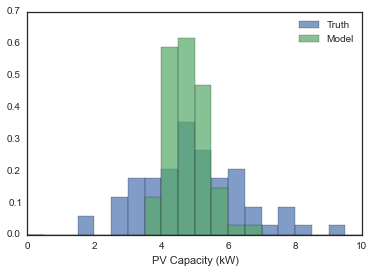

In [268]:
# plot histogram of test data results
plt.hist(y_test, alpha=0.7, range=[0,10], bins=20, normed=True, label='Truth')
plt.hist(y_predict, alpha=0.7, range=[0,10], bins=20, normed=True, label='Model')
plt.legend()
plt.xlabel('PV Capacity (kW)')
plt.savefig('model_test.pdf')

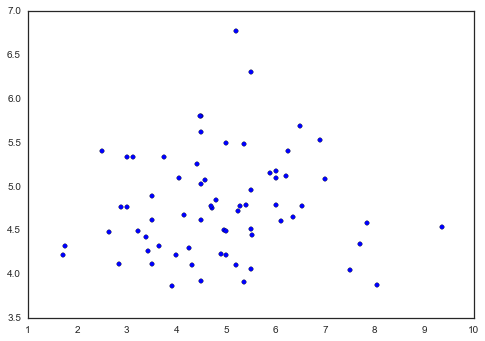

In [153]:
plt.scatter(y_test, y_predict)

In [198]:
# time to make predictions
propertyPredict = propertyAssessment[['LU', 'NUM_FLOORS', 'AV_BLDG', 'YR_BUILT', 'R_AC', 'OWN_OCC', \
                             'R_TOTAL_RMS', 'GROSS_TAX', 'R_ROOF_TYP']]

# normalize data
propertyPredict = normalize_data(propertyPredict, 'AV_BLDG')
propertyPredict = normalize_data(propertyPredict, 'YR_BUILT')

for i in xrange(0,16):
    if LU[i] == 'R1':
        propertyPredict['LU'].values[np.where(propertyPredict['LU'].values == LU[i])] = 1.0
    else:
        propertyPredict['LU'].values[np.where(propertyPredict['LU'].values == LU[i])] = -1.0
        
# filter out nan floors
propertyPredict['NUM_FLOORS'] = propertyPredict['NUM_FLOORS'].values.astype(float)
ind = np.where(propertyPredict['NUM_FLOORS'] > 100) 
propertyPredict['NUM_FLOORS'].values[ind] = 0
ind = np.where(propertyPredict['NUM_FLOORS'] == 0)
mu = np.mean(propertyPredict['NUM_FLOORS'])
propertyPredict['NUM_FLOORS'].values[ind] = mu 

propertyPredict = normalize_data(propertyPredict, 'NUM_FLOORS')

# code AC and OWNER OCCUPIED TO +/-1 
propertyPredict['R_AC'].values[np.where((propertyPredict['R_AC'].values != 'C') & 
                                     (propertyPredict['R_AC'].values != 'D'))] = -1.0
propertyPredict['R_AC'].values[np.where((propertyPredict['R_AC'].values == 'C') | 
                                     (propertyPredict['R_AC'].values == 'D'))] = 1.0
propertyPredict['OWN_OCC'].values[np.where(propertyPredict['OWN_OCC'].values != 'Y')] = -1.0
propertyPredict['OWN_OCC'].values[np.where(propertyPredict['OWN_OCC'].values == 'Y')] = 1.0

ind = np.where(propertyPredict['GROSS_TAX'] > 50000)
propertyPredict['GROSS_TAX'].values[ind] = 0
propertyPredict = normalize_data(propertyPredict, 'GROSS_TAX')

propertyPredict = normalize_data(propertyPredict, 'R_TOTAL_RMS')

propertyPredict['R_ROOF_TYP'].values[np.where((propertyPredict['R_ROOF_TYP'].values != 'F') & 
                                           (propertyPredict['R_ROOF_TYP'].values != 'G') &
                                           (propertyPredict['R_ROOF_TYP'].values != 'H') & 
                                           (propertyPredict['R_ROOF_TYP'].values != 'M'))] = -1.0
propertyPredict['R_ROOF_TYP'].values[np.where((propertyPredict['R_ROOF_TYP'].values == 'F') | 
                                           (propertyPredict['R_ROOF_TYP'].values == 'M'))] = 1.0
propertyPredict['R_ROOF_TYP'].values[np.where((propertyPredict['R_ROOF_TYP'].values == 'G') | 
                                           (propertyPredict['R_ROOF_TYP'].values == 'H'))] = 0.0

X_predict = propertyPredict.values

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [199]:
X_predict[:,0] = X_predict[:,0].astype(int)
X_predict[np.where(X_predict[:,0] < -1.6), 0] = 0
print np.min(X_predict[:,0])

-1


In [210]:
X_predict[:,2] = X_predict[:,2].astype(float)
X_predict[:,0] = X_predict[:,0].astype(int)
print np.min(X_predict[:,8])

-1.0


In [211]:
X_predict = X_predict.astype(float)
X_predict[np.where(np.isnan(X_predict))] = 0

In [212]:
y_all = nn.predict(X_predict)

In [213]:
print np.max(y_all)
print np.min(y_all)

3.66125366205e+18
2.30536861343


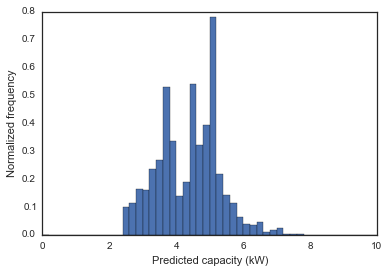

In [267]:
plt.hist(y_all, range=[0,10], bins=50, normed=True)
plt.xlabel('Predicted capacity (kW)')
plt.ylabel('Normalized frequency')
plt.savefig('predicted_capacity.pdf')

In [215]:
predicted_boston = propertyAssessment
predicted_boston['Prediction'] = y_all

In [221]:
# make map of predictions
propertyAssessment['Location']

0         (42.340297000, -71.166757000)
1         (42.340294000, -71.166405000)
2         (42.340530000, -71.166340000)
3         (42.340509000, -71.166674000)
4         (42.340881000, -71.166627000)
5         (42.340780000, -71.166340000)
6         (42.340804000, -71.166338000)
7         (42.340780000, -71.166340000)
8         (42.340950000, -71.166350000)
9         (42.341090000, -71.166340000)
10        (42.341160000, -71.166340000)
11        (42.341300000, -71.166310000)
12        (42.341360000, -71.166310000)
13        (42.341570000, -71.166250000)
14        (42.341760000, -71.166290000)
15        (42.341900000, -71.166720000)
16        (42.341770000, -71.166740000)
17        (42.341640000, -71.166760000)
18        (42.341480000, -71.166730000)
19        (42.341310000, -71.166740000)
20        (42.341160000, -71.166760000)
21        (42.341180000, -71.167250000)
22        (42.341350000, -71.167230000)
23        (42.341530000, -71.167210000)
24        (42.341710000, -71.167200000)


In [216]:
reduced_predictions = predicted_boston[['Parcel_ID', 'OWNER', 'Prediction']]
reduced_predictions.to_json('predictions_fourth_attempt.json' )

In [230]:
requests.post('https://obscure-ridge-64270.herokuapp.com/', data=json.dumps('./jsondump.json'))

<Response [503]>

In [219]:
reduced_predictions.axes

[Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                  8,      9, 
             ...
             164081, 164082, 164083, 164084, 164085, 164086, 164087, 164088,
             164089, 164090],
            dtype='int64', length=164091),
 Index([u'Parcel_ID', u'OWNER', u'Prediction'], dtype='object')]

In [786]:
test = predicted_boston[0:1]
test.to_json('predictions_first_attempt.json')

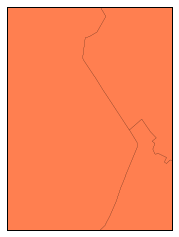

In [276]:
my_map = Basemap(projection='merc', lat_0 = 42.3601, lon_0 = -71.0589,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=-71.1, llcrnrlat=42.4,
    urcrnrlon=-71.0, urcrnrlat=42.5)
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawcounties()
my_map.fillcontinents(color = 'coral')
my_map.drawmapboundary()

lat = float(propertyAssessment.loc[164080]['Location'][1:13])
lon = float(propertyAssessment.loc[164080]['Location'][15:26])
x,y = my_map(lon, lat)
my_map.plot(x, y, 'go', markersize=10)

In [229]:
# format for json 
my_json = open("predictions_fourth_attempt.json").read()

data = json.loads(my_json)
cleaned_json = []

for row in range(2500):
    temp_json = {}
    for item in data:
        data_item = data[item][str(row)]
        if item=="OWNER":
            temp_json[item.decode('ascii')] = data[item][str(row)].decode('ascii')
        else:
            temp_json[item.decode('ascii')] = data[item][str(row)]
    cleaned_json.append(temp_json)
final_json = {}
final_json["batch"] = cleaned_json
# headers = {'content-type': 'application/json'}
# r= requests.post('https://obscure-ridge-64270.herokuapp.com/',headers=heas data = final_json)
with open('jsondump.json', 'wb') as outfile:
    json.dump(final_json, outfile)


In [235]:
nn.get_parameters()

[Parameters(weights=array([[ 0.62145513, -0.07799507, -0.19412927, -0.29867785, -0.32677921,
         0.16532208,  0.26891875, -0.50411045],
       [ 0.47323847,  0.16637821, -0.00340439,  0.00991601, -0.46873681,
        -0.23080954, -0.53048856, -0.06485983],
       [ 0.28343591, -0.0668253 , -0.31936018, -0.22434416,  0.39091701,
         0.13677752, -0.45819766, -0.31405239],
       [ 0.37258532,  0.00666495,  0.35188361,  0.26439317,  0.09396052,
         0.51407934, -0.42148173,  0.51174612],
       [ 0.58271436,  0.30986546,  0.21279158,  0.27320917,  0.19521207,
        -0.26699145, -0.16408647, -0.48599006],
       [ 0.31742082, -0.12894558, -0.12872537,  0.36817632,  0.40317846,
        -0.39416372,  0.16532936,  0.26042   ],
       [ 0.59464775, -0.12284918, -0.30217465,  0.23519347,  0.51442713,
        -0.44117533, -0.2502832 ,  0.12764431],
       [-0.27381015,  0.29468493, -0.14402106, -0.39985048,  0.00604804,
        -0.51396522, -0.20756378, -0.4701711 ],
       [ 0.4